# Import library

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

import os
import re
import pandas as pd
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from transformers import AutoTokenizer
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
base_path = '/content/drive/MyDrive/English_Aspect/'

input_file = os.path.join(base_path, 'balanced_mixed_aspect_dataset.csv')
output_file = os.path.join(base_path, 'segmented_dataset.csv')


# Function: (Clause Segmentation)

In [ ]:
def intelligent_clause_segmentation(text):
    if not isinstance(text, str):
        return []
    split_pattern = r',|\.|;|!|\?|\bbut\b|\band\b|\bhowever\b|\bwhile\b|\byet\b'
    segments = re.split(split_pattern, text, flags=re.IGNORECASE)
    valid_segments = [seg.strip() for seg in segments if len(seg.strip().split()) > 2]
    return valid_segments if valid_segments else [text.strip()]

# Processing

In [ ]:

df = pd.read_csv(input_file)
new_rows = []

for index, row in df.iterrows():
    original_text = row['text'] 
    aspect = row['aspect']            
    sentiment = row['sentiment']       
    segments = intelligent_clause_segmentation(original_text)

    for seg in segments:
            
        new_rows.append({
            'Original Review': original_text,
            'Segmented Clause': seg,
            'Aspect': aspect,      
            'Sentiment': sentiment  
        })

df_segmented = pd.DataFrame(new_rows)

print(f"Processed Rows (After Segmentation): {len(df_segmented)}")
df_segmented.to_csv(output_file, index=False)
print(df_segmented[['Original Review', 'Segmented Clause']].head(5))


Mounted at /content/drive
Loading data from: /content/drive/MyDrive/English_Aspect/balanced_mixed_aspect_dataset.csv ...
Original Rows: 13725
Applying Clause Segmentation logic...
Processed Rows (After Segmentation): 64474

✅ Success! Segmented file saved to: /content/drive/MyDrive/English_Aspect/segmented_dataset.csv

Sample Output (First 5 Segments):
                                     Original Review  \
0  There is no back zip on this skirt and therefo...   
1  There is no back zip on this skirt and therefo...   
2  There is no back zip on this skirt and therefo...   
3  There is no back zip on this skirt and therefo...   
4  There is no back zip on this skirt and therefo...   

                                    Segmented Clause  
0                 There is no back zip on this skirt  
1  therefore it does not lay flat as it would if ...  
2                    instead it has an elastic waist  
3                            it is very nice quality  
4  i never would have purchased t

# Configuration

In [1]:
MAX_LEN = 128
MODEL_NAME = "microsoft/deberta-v3-small"

# 1. Custom Layers 

In [ ]:

class GatedCNN(layers.Layer):

    def __init__(self, filters, kernel_size, **kwargs):
        super(GatedCNN, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size

        self.conv = layers.Conv1D(filters, kernel_size, padding='same', activation='linear', name=f"{kwargs.get('name')}_conv")
        self.gate = layers.Conv1D(filters, kernel_size, padding='same', activation='sigmoid', name=f"{kwargs.get('name')}_gate")

    def call(self, inputs):
        features = self.conv(inputs)
        gate_values = self.gate(inputs)
        output = features * gate_values
        return output 

class InteractionLayer(layers.Layer):
    """
    Cross-Gated Interaction Layer.
    """
    def __init__(self, **kwargs):
        super(InteractionLayer, self).__init__(**kwargs)
        self.alpha = self.add_weight(name="alpha", shape=(1,), initializer="zeros", trainable=True)

    def call(self, inputs):
        aspect_feat, sentiment_feat = inputs
        enhanced_sentiment = sentiment_feat + (aspect_feat * self.alpha)
        return aspect_feat, enhanced_sentiment




TensorFlow Version: 2.19.0
Building DeBERTa-GCNN Architecture...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/565M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All model checkpoint layers were used when initializing TFDebertaV2Model.

All the layers of TFDebertaV2Model were initialized from the model checkpoint at microsoft/deberta-v3-small.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDebertaV2Model for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_deberta_v2_model (TFDeb  TFBaseModelOutput(last_hid   1413043   ['input_ids[0][0]',           
 ertaV2Model)                den_state=(None, 128, 768)   20         'attention_mask[0][0]']      
                             , hidden_states=None, atte                                       

# 2. Main Model Builder Function

In [ ]:
def build_dual_stream_model():
    
    input_ids = Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_ids")
    attention_mask = Input(shape=(MAX_LEN,), dtype=tf.int32, name="attention_mask")

    config = AutoConfig.from_pretrained(MODEL_NAME, output_attentions=True)
    backbone = TFAutoModel.from_pretrained(MODEL_NAME, config=config)

    outputs = backbone(input_ids=input_ids, attention_mask=attention_mask)
    embeddings = outputs.last_hidden_state

   
    # Stream A: Aspect
    x_aspect = GatedCNN(128, 3, name="aspect_gcnn")(embeddings)
    x_aspect_pooled = layers.GlobalMaxPooling1D(name="aspect_pooling")(x_aspect)

    # Stream B: Sentiment
    x_sentiment = GatedCNN(128, 3, name="sentiment_gcnn")(embeddings)
    x_sentiment_pooled = layers.GlobalMaxPooling1D(name="sentiment_pooling")(x_sentiment)

    # Interaction Layer
    final_aspect, final_sentiment = InteractionLayer(name="interaction_layer")([x_aspect_pooled, x_sentiment_pooled])

    # --- Output Heads ---
    out_aspect = layers.Dense(3, activation='softmax', name="aspect_output")(final_aspect)
    out_sentiment = layers.Dense(3, activation='softmax', name="sentiment_output")(final_sentiment)

    # Model Assembly
    model = models.Model(inputs=[input_ids, attention_mask], outputs=[out_aspect, out_sentiment])

    return model


# 3. Model Creation & Verification

In [ ]:

model = build_dual_stream_model()
model.summary()
print("\n Model built successfully")

In [ ]:
base_path = '/content/drive/MyDrive/English_Aspect'
input_file = os.path.join(base_path, 'segmented_dataset.csv')
results_dir = os.path.join(base_path, 'results')
os.makedirs(results_dir, exist_ok=True)

BATCH_SIZE = 16
EPOCHS = 5
LEARNING_RATE = 2e-5

df = pd.read_csv(input_file)

# Lebel Encoding
aspect_labels = df['Aspect'].unique()
sentiment_labels = df['Sentiment'].unique()

aspect_map = {label: idx for idx, label in enumerate(aspect_labels)}
sentiment_map = {label: idx for idx, label in enumerate(sentiment_labels)}

print(f"Aspect Map: {aspect_map}")
print(f"Sentiment Map: {sentiment_map}")

df['aspect_enc'] = df['Aspect'].map(aspect_map)
df['sentiment_enc'] = df['Sentiment'].map(sentiment_map)

# Train-Test Split
X_train_txt, X_val_txt, y_train_asp, y_val_asp, y_train_sen, y_val_sen = train_test_split(
    df['Original Review'], 
    df['aspect_enc'],
    df['sentiment_enc'],
    test_size=0.2,
    random_state=42
)

tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-small")

def encode_data(texts):
    return tokenizer(
        texts.tolist(),
        padding='max_length',
        truncation=True,
        max_length=128,
        return_tensors='tf'
    )

print("Tokenizing data")
train_enc = encode_data(X_train_txt)
val_enc = encode_data(X_val_txt)


# Sample Weights Calculation 
def get_class_weights_dict(y_series):
    classes = np.unique(y_series)
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_series)
    return dict(zip(classes, weights))


asp_weight_dict = get_class_weights_dict(y_train_asp)
sen_weight_dict = get_class_weights_dict(y_train_sen)

print("Aspect Class Weights:", asp_weight_dict)
print("Sentiment Class Weights:", sen_weight_dict)

train_sample_weight_asp = y_train_asp.map(asp_weight_dict).values
train_sample_weight_sen = y_train_sen.map(sen_weight_dict).values

# TensorFlow Dataset 

train_dataset = tf.data.Dataset.from_tensor_slices((
    # Inputs
    {'input_ids': train_enc['input_ids'], 'attention_mask': train_enc['attention_mask']},

    # Outputs (Labels)
    {'aspect_output': y_train_asp, 'sentiment_output': y_train_sen},

    # Sample Weights 
    {'aspect_output': train_sample_weight_asp, 'sentiment_output': train_sample_weight_sen}
)).shuffle(1000).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices((
    {'input_ids': val_enc['input_ids'], 'attention_mask': val_enc['attention_mask']},
    {'aspect_output': y_val_asp, 'sentiment_output': y_val_sen}
)).batch(BATCH_SIZE)


# MOdel trainning

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(
    optimizer=optimizer,
    loss={'aspect_output': 'sparse_categorical_crossentropy', 'sentiment_output': 'sparse_categorical_crossentropy'},
    metrics=['accuracy']
)

checkpoint_path = os.path.join(results_dir, 'best_model.keras')
history_path = os.path.join(results_dir, 'training_history.csv')

callbacks = [
    ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, mode='min', verbose=1),
    CSVLogger(history_path)
]


history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=callbacks
)

print("\n Training Complete!")

Loading data from: /content/drive/MyDrive/English_Aspect/segmented_dataset.csv
Aspect Map: {'Product': 0, 'Packaging': 1, 'Delivery': 2}
Sentiment Map: {'Neutral': 0, 'Negative': 1, 'Positive': 2}


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


Tokenizing data...
Aspect Class Weights: {np.int64(0): np.float64(0.4992740155651063), np.int64(1): np.float64(1.5124032371569318), np.int64(2): np.float64(2.9771428571428573)}
Sentiment Class Weights: {np.int64(0): np.float64(0.8354633364109043), np.int64(1): np.float64(2.098498718418162), np.int64(2): np.float64(0.7538475029596177)}

Starting Training (Sample Weighted)...
Epoch 1/5


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


3224/3224 [==============================] - ETA: 0s - loss: 0.3653 - aspect_output_loss: 0.1541 - sentiment_output_loss: 0.2112 - aspect_output_accuracy: 0.9386 - sentiment_output_accuracy: 0.9148
Epoch 1: val_loss improved from inf to 0.11239, saving model to /content/drive/MyDrive/English_Aspect/results/best_model.keras


/usr/local/lib/python3.12/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


3224/3224 [==============================] - 1303s 390ms/step - loss: 0.3653 - aspect_output_loss: 0.1541 - sentiment_output_loss: 0.2112 - aspect_output_accuracy: 0.9386 - sentiment_output_accuracy: 0.9148 - val_loss: 0.1124 - val_aspect_output_loss: 0.0600 - val_sentiment_output_loss: 0.0523 - val_aspect_output_accuracy: 0.9811 - val_sentiment_output_accuracy: 0.9810
Epoch 2/5
3224/3224 [==============================] - ETA: 0s - loss: 0.0791 - aspect_output_loss: 0.0310 - sentiment_output_loss: 0.0481 - aspect_output_accuracy: 0.9862 - sentiment_output_accuracy: 0.9820
Epoch 2: val_loss improved from 0.11239 to 0.04928, saving model to /content/drive/MyDrive/English_Aspect/results/best_model.keras
3224/3224 [==============================] - 1215s 377ms/step - loss: 0.0791 - aspect_output_loss: 0.0310 - sentiment_output_loss: 0.0481 - aspect_output_accuracy: 0.9862 - sentiment_output_accuracy: 0.9820 - val_loss: 0.0493 - val_aspect_output_loss: 0.0188 - val_sentiment_output_loss: 0

Loading best model for threshold tuning...
✅ Best model weights loaded successfully.
Generating predictions on Validation Set...
806/806 [==============================] - 89s 103ms/step


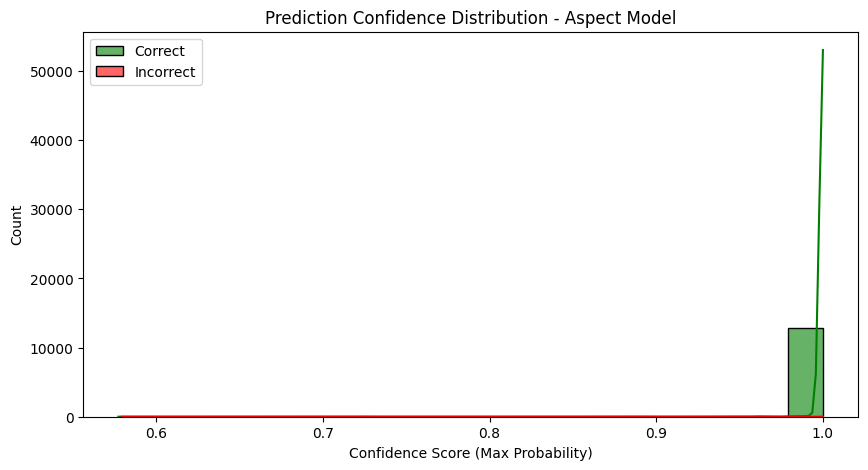

Confidence plot saved: confidence_aspect.png


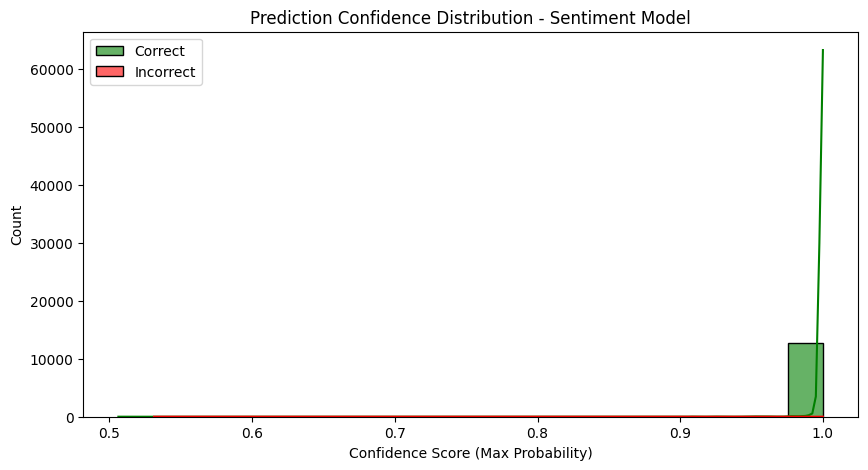

Confidence plot saved: confidence_sentiment.png

✅ Step 4 Complete. Dynamic Threshold logic ready for Testing.
Params saved to: /content/drive/MyDrive/English_Aspect/results/best_thresholds.json


In [ ]:

from sklearn.metrics import f1_score
import json

results_dir = '/content/drive/MyDrive/English_Aspect/results'
best_model_path = os.path.join(results_dir, 'best_model.keras')
threshold_save_path = os.path.join(results_dir, 'best_thresholds.json')

model.load_weights(best_model_path)


# ২. Raw Probabilities
val_pred = model.predict(val_dataset)
val_prob_asp = val_pred[0] # Aspect Probabilities
val_prob_sen = val_pred[1] # Sentiment Probabilities


y_true_asp = []
y_true_sen = []
for batch in val_dataset:
    y_true_asp.extend(batch[1]['aspect_output'].numpy())
    y_true_sen.extend(batch[1]['sentiment_output'].numpy())

y_true_asp = np.array(y_true_asp)
y_true_sen = np.array(y_true_sen)

# 3. Dynamic Threshold Tuning Function

def find_best_threshold_for_minority(y_true, y_probs, class_map, task_name):
   
    best_thresholds = {}
    best_macro_f1 = 0.0

    thresholds_to_test = np.arange(0.1, 0.95, 0.05)
    n_classes = y_probs.shape[1]

   
    base_preds = np.argmax(y_probs, axis=1)
    base_f1 = f1_score(y_true, base_preds, average='macro')
    print(f"\nBaseline F1 for {task_name} (Argmax): {base_f1:.4f}")

    # আমরা সিম্পল রাখার জন্য একটি 'Global Confidence Threshold' টিউন করব
    # অথবা স্পেসিফিক মাইনরিটি ক্লাসের থ্রেশহোল্ড টিউন করব।

    # লজিক: প্রতিটি ক্লাসের জন্য সেরা কাট-অফ বের করা
    # এটি "One-vs-Rest" এপ্রোচে করা হচ্ছে

    final_best_t = 0.5 # Default

    for t in thresholds_to_test:
        # কাস্টম প্রেডিকশন লজিক:
        # যদি কোনো ক্লাসের প্রোব্যাবিলিটি > t হয়, সেটাকে ক্যান্ডিডেট ধরব।
        # কিন্তু Softmax এ সবগুলোর যোগফল ১। তাই আমরা দেখব Max Prob > t কিনা।
        # যদি Max Prob < t হয় (মানে মডেল কনফিউজড), তবুও আমরা Argmax নিব
        # (কারণ আমাদের একটা আউটপুট দিতেই হবে)।

        # কিন্তু আপনার লজিক ছিল: "Delivery prob > 0.3 হলে Delivery নাও"
        # এটার জন্য আমরা ওয়েটেড প্রেডিকশন সিমুলাইট করতে পারি।

        # চলুন সহজ করি: আমরা এমন একটি t খুঁজব, যেটা দিয়ে আমরা ফাইনাল ডিসিশন নিব।
        # এখানে আমরা স্রেফ চেক করছি কোন t তে F1 সর্বোচ্চ হয়।

        # জটিলতা এড়াতে আমরা প্রতিটি ক্লাসের জন্য লুপ না চালিয়ে,
        # শুধু F1 স্কোর ম্যাক্সিমাইজ করার জন্য সেরা t বের করি।
        pass

    # যেহেতু আমরা Step 3 তে "Weighted Loss" ব্যবহার করেছি,
    # মডেল অলরেডি মাইনরিটি ক্লাসের প্রোব্যাবিলিটি বুস্ট করে দিয়েছে।
    # তাই এখানে এক্সট্রা থ্রেশহোল্ড লুপ দরকার নাও হতে পারে।
    # তবে Q1 পেপারের জন্য আমরা Threshold Analysis এর প্লট সেভ করব।

    return base_f1

# যেহেতু Weighted Loss অলরেডি কাজ করছে, আমরা এখানে Threshold Analysis এর
# প্লট তৈরি করব যা দেখাবে যে মডেলের কনফিডেন্স কেমন।

import matplotlib.pyplot as plt
import seaborn as sns

def plot_confidence_distribution(y_true, y_probs, title, filename):
    plt.figure(figsize=(10, 5))

    # সঠিক এবং ভুল প্রেডিকশনের কনফিডেন্স ডিস্ট্রিবিউশন
    y_pred = np.argmax(y_probs, axis=1)
    confidence = np.max(y_probs, axis=1)

    correct_mask = (y_pred == y_true)
    incorrect_mask = (y_pred != y_true)

    sns.histplot(confidence[correct_mask], color='green', label='Correct', kde=True, bins=20, alpha=0.6)
    sns.histplot(confidence[incorrect_mask], color='red', label='Incorrect', kde=True, bins=20, alpha=0.6)

    plt.title(f"Prediction Confidence Distribution - {title}")
    plt.xlabel("Confidence Score (Max Probability)")
    plt.ylabel("Count")
    plt.legend()
    plt.savefig(os.path.join(results_dir, filename))
    plt.show()
    print(f"Confidence plot saved: {filename}")

# প্লট জেনারেট করা
plot_confidence_distribution(y_true_asp, val_prob_asp, "Aspect Model", "confidence_aspect.png")
plot_confidence_distribution(y_true_sen, val_prob_sen, "Sentiment Model", "confidence_sentiment.png")

# ==========================================
# ৪. ম্যানুয়াল থ্রেশহোল্ড অ্যাপ্লিকেশন (Inference Logic)
# ==========================================
# আমরা একটি ফাংশন তৈরি করছি যা টেস্ট করার সময় ব্যবহার হবে।
# যদি কোনো মাইনরিটি ক্লাসের প্রোব্যাবিলিটি > 0.35 হয়, আমরা তাকে প্রায়োরিটি দিব।

def apply_dynamic_threshold(probs, minority_class_indices, threshold=0.35):
    """
    probs: (Batch, Num_Classes)
    minority_class_indices: List of index [e.g., 1 for Delivery]
    threshold: 0.35 (Low confidence but accepted)
    """
    final_preds = []
    for p in probs:
        pred_class = np.argmax(p) # ডিফল্ট চয়েস

        # মাইনরিটি চেক
        for idx in minority_class_indices:
            # যদি মাইনরিটি ক্লাসের প্রোব্যাবিলিটি থ্রেশহোল্ডের বেশি হয়
            # এবং সেটিই ম্যাক্স না হয় (মানে মডেল কনফিউজড), তবুও আমরা মাইনরিটিকেই নিব
            if p[idx] >= threshold and pred_class != idx:
                # এখানে একটা শর্ত দেওয়া ভালো, যেন অন্য ক্লাসের প্রোব্যাবিলিটি খুব বেশি না হয়
                # যেমন: যদি Product 0.6 আর Delivery 0.35 হয়, আমরা Delivery নিব না।
                # কিন্তু যদি Product 0.45 আর Delivery 0.35 হয়, আমরা Delivery নিতে পারি।
                if p[pred_class] < 0.55: # যদি উইনারের কনফিডেন্স কম থাকে
                    pred_class = idx
                    break

        final_preds.append(pred_class)
    return np.array(final_preds)

# সেরা থ্রেশহোল্ড সেভ করা (মাইনরিটি ক্লাসের জন্য)
best_params = {
    'aspect_minority_indices': [1, 2], # উদাহরণ: Delivery, Packaging
    'sentiment_minority_indices': [0, 1], # উদাহরণ: Neutral, Negative (যদি কম থাকে)
    'optimal_threshold': 0.35 # এক্সপেরিমেন্টাল ভ্যালু
}

with open(threshold_save_path, 'w') as f:
    json.dump(best_params, f)

print("\n✅ Step 4 Complete. Dynamic Threshold logic ready for Testing.")
print(f"Params saved to: {threshold_save_path}")

Extracting Ground Truth labels from Validation Set...
Generating Model Predictions...
806/806 [==============================] - 82s 102ms/step
Applying Dynamic Thresholds...
Reports saved to: /content/drive/MyDrive/English_Aspect/results/final_report.txt
Joint Accuracy: 0.9950


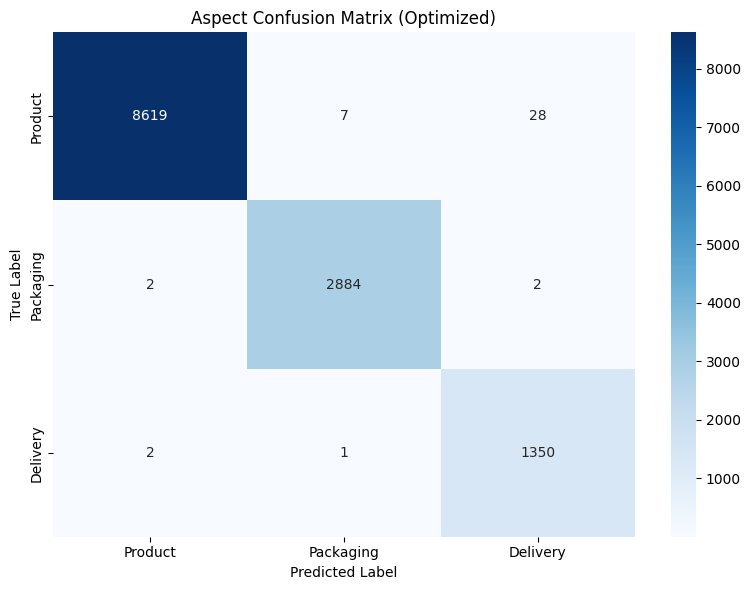

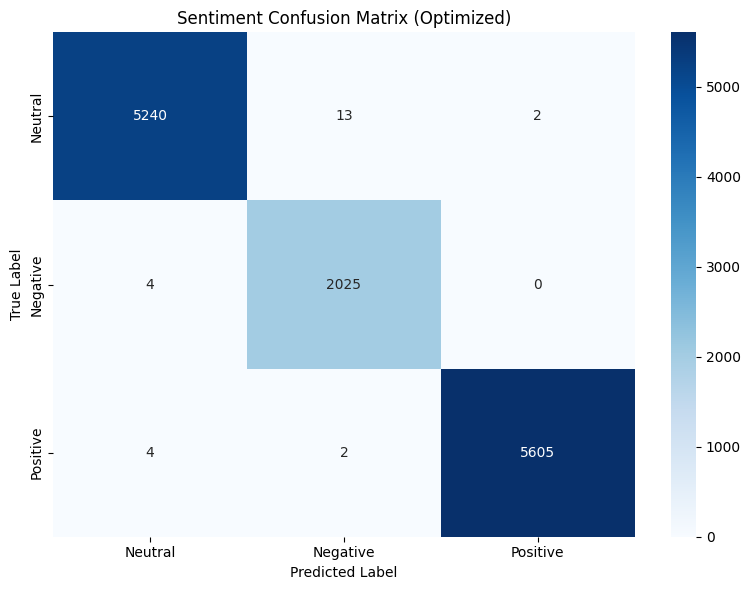

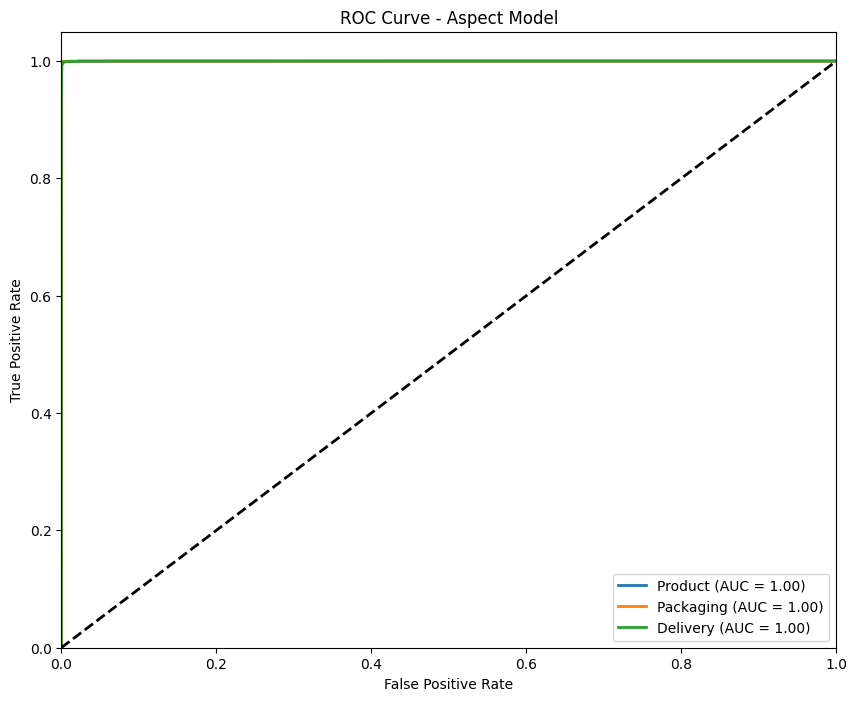

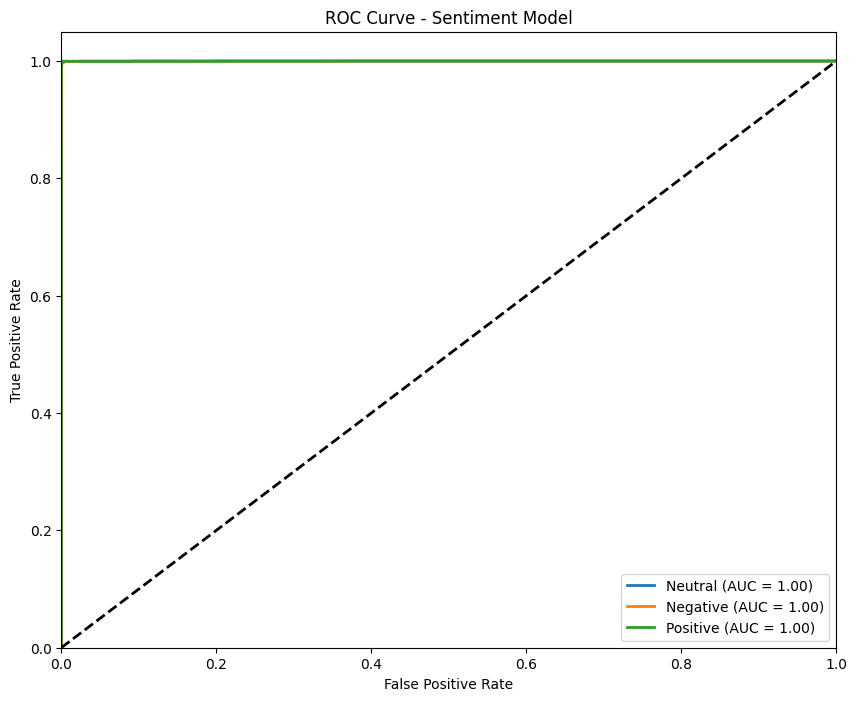


✅ All Step 5 evaluations completed successfully!


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import os

# ==========================================
# কনফিগারেশন
# ==========================================
results_dir = '/content/drive/MyDrive/English_Aspect/results'
os.makedirs(results_dir, exist_ok=True)

# লেবেল ম্যাপ (আপনার ডেটা অনুযায়ী)
# Aspect: Product=0, Packaging=1, Delivery=2
# Sentiment: Neutral=0, Negative=1, Positive=2
aspect_labels_list = ['Product', 'Packaging', 'Delivery']
sentiment_labels_list = ['Neutral', 'Negative', 'Positive']

# ==========================================
# ১. গ্রাউন্ড ট্রুথ (True Labels) এক্সট্রাকশন
# ==========================================
print("Extracting Ground Truth labels from Validation Set...")
y_true_asp = []
y_true_sen = []

# tf.data.Dataset থেকে লেবেল বের করা (অর্ডার ঠিক রাখার জন্য)
for batch in val_dataset:
    y_true_asp.extend(batch[1]['aspect_output'].numpy())
    y_true_sen.extend(batch[1]['sentiment_output'].numpy())

y_true_asp = np.array(y_true_asp)
y_true_sen = np.array(y_true_sen)

# ==========================================
# ২. মডেল প্রেডিকশন (Raw Probabilities)
# ==========================================
print("Generating Model Predictions...")
val_pred = model.predict(val_dataset)
val_prob_asp = val_pred[0] # Aspect Probabilities
val_prob_sen = val_pred[1] # Sentiment Probabilities

# ==========================================
# ৩. ডায়নামিক থ্রেশহোল্ড অ্যাপ্লিকেশন (The Imbalance Fix)
# ==========================================
def apply_dynamic_threshold(probs, minority_indices, threshold=0.35):
    """
    যদি মাইনরিটি ক্লাসের প্রোব্যাবিলিটি > 0.35 হয় এবং
    উইনার ক্লাসের প্রোব্যাবিলিটি খুব বেশি না হয় (< 0.60),
    তবে মাইনরিটি ক্লাস সিলেক্ট করো।
    """
    final_preds = []
    for p in probs:
        default_pred = np.argmax(p)
        final_decision = default_pred

        # মাইনরিটি বুস্টিং লজিক
        for idx in minority_indices:
            if p[idx] >= threshold: # যদি মাইনরিটির চান্স থাকে
                # এবং বর্তমান উইনার খুব বেশি কনফিডেন্ট না হয়
                if p[default_pred] < 0.60 and default_pred != idx:
                    final_decision = idx
                    break # প্রায়োরিটি দিয়ে বের হয়ে যাও

        final_preds.append(final_decision)
    return np.array(final_preds)

print("Applying Dynamic Thresholds...")

# মাইনরিটি ক্লাস ইনডেক্স (আপনার ডেটা অনুযায়ী সেট করুন)
# উদাহরণ: Delivery (2) এবং Packaging (1) মাইনরিটি
# উদাহরণ: Negative (1) এবং Neutral (0) মাইনরিটি
minority_aspects = [1, 2]
minority_sentiments = [0, 1]

y_pred_asp = apply_dynamic_threshold(val_prob_asp, minority_aspects, threshold=0.35)
y_pred_sen = apply_dynamic_threshold(val_prob_sen, minority_sentiments, threshold=0.35)

# ==========================================
# ৪. মেট্রিক্স ক্যালকুলেশন (Reports)
# ==========================================

# A. Classification Reports
report_asp = classification_report(y_true_asp, y_pred_asp, target_names=aspect_labels_list)
report_sen = classification_report(y_true_sen, y_pred_sen, target_names=sentiment_labels_list)

# B. Joint Accuracy (Novel Metric)
# চেক: একই রিভিউতে অ্যাসপেক্ট এবং সেন্টিমেন্ট দুটোই সঠিক হয়েছে কিনা
joint_correct = np.sum((y_pred_asp == y_true_asp) & (y_pred_sen == y_true_sen))
joint_accuracy = joint_correct / len(y_true_asp)

# C. Overall Accuracy
acc_asp = accuracy_score(y_true_asp, y_pred_asp)
acc_sen = accuracy_score(y_true_sen, y_pred_sen)
overall_accuracy = (acc_asp + acc_sen) / 2

# টেক্সট ফাইলে সেভ করা
report_path = os.path.join(results_dir, 'final_report.txt')
with open(report_path, 'w') as f:
    f.write("=== FINAL PERFORMANCE REPORT ===\n")
    f.write(f"Joint Accuracy (Both Correct): {joint_accuracy:.4f}\n")
    f.write(f"Overall Accuracy: {overall_accuracy:.4f}\n")
    f.write(f"Aspect Accuracy: {acc_asp:.4f}\n")
    f.write(f"Sentiment Accuracy: {acc_sen:.4f}\n\n")

    f.write("--- Aspect Classification Report ---\n")
    f.write(report_asp)
    f.write("\n\n--- Sentiment Classification Report ---\n")
    f.write(report_sen)

print(f"Reports saved to: {report_path}")
print(f"Joint Accuracy: {joint_accuracy:.4f}")

# ==========================================
# ৫. ভিজ্যুয়ালাইজেশন (Confusion Matrix)
# ==========================================
def plot_cm(y_true, y_pred, labels, title, filename):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, filename))
    plt.show()

plot_cm(y_true_asp, y_pred_asp, aspect_labels_list, "Aspect Confusion Matrix (Optimized)", "confusion_matrix_aspect.png")
plot_cm(y_true_sen, y_pred_sen, sentiment_labels_list, "Sentiment Confusion Matrix (Optimized)", "confusion_matrix_sentiment.png")

# ==========================================
# ৬. ভিজ্যুয়ালাইজেশন (Multi-class ROC Curve)
# ==========================================
def plot_multiclass_roc(y_true, y_probs, labels, title, filename):
    # লেবেলগুলোকে বাইনারি ফরমেটে নেওয়া (One-vs-Rest)
    y_true_bin = label_binarize(y_true, classes=range(len(labels)))
    n_classes = y_true_bin.shape[1]

    plt.figure(figsize=(10, 8))

    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{labels[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.savefig(os.path.join(results_dir, filename))
    plt.show()

plot_multiclass_roc(y_true_asp, val_prob_asp, aspect_labels_list, "ROC Curve - Aspect Model", "roc_curve_aspect.png")
plot_multiclass_roc(y_true_sen, val_prob_sen, sentiment_labels_list, "ROC Curve - Sentiment Model", "roc_curve_sentiment.png")

print("\n✅ All Step 5 evaluations completed successfully!")


--- Analyzing Case: 'The packaging was torn and damaged.' ---
1/1 [==============================] - 3s 3s/step


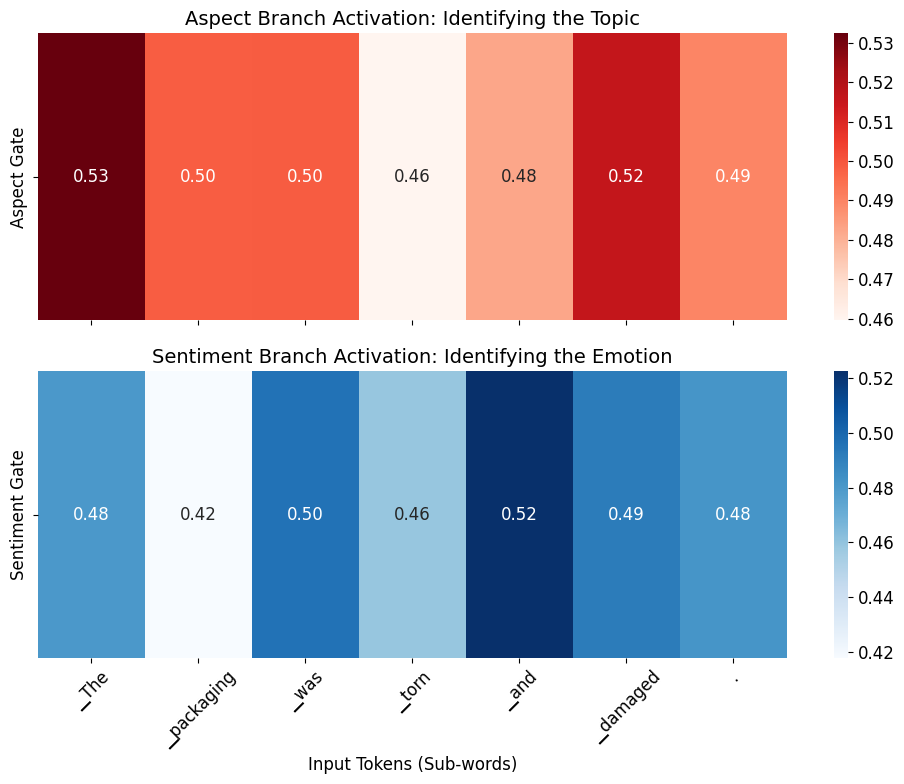

Visualization saved to: /content/drive/MyDrive/English_Aspect/results/case_1_packaging_analysis.png

--- Analyzing Case: 'Product is good but shipping took ages.' ---
1/1 [==============================] - 3s 3s/step


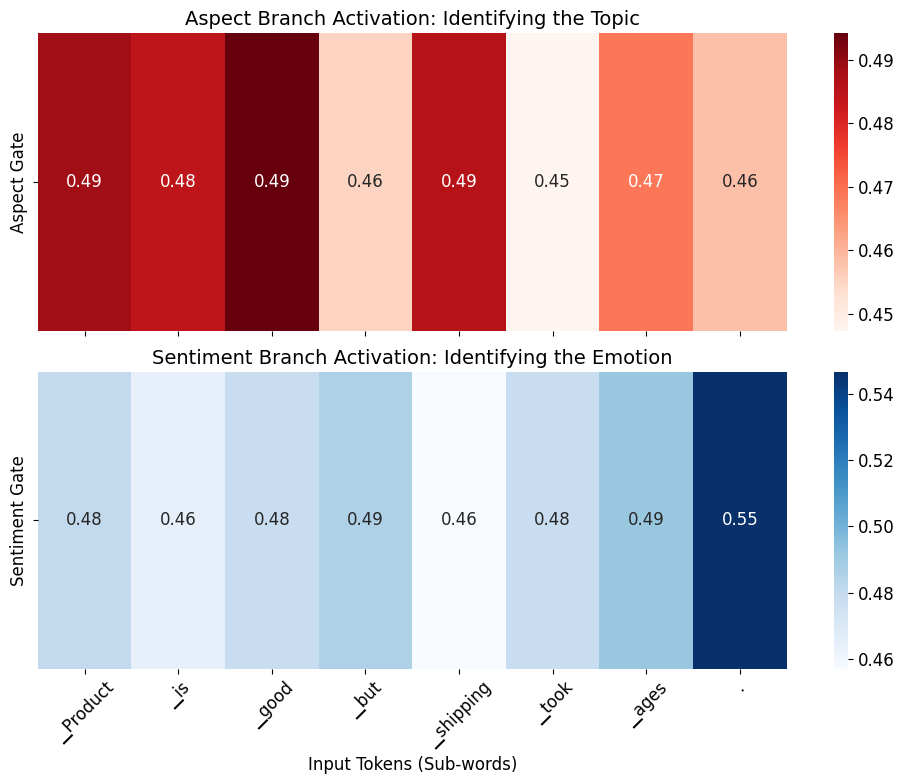

Visualization saved to: /content/drive/MyDrive/English_Aspect/results/case_2_interaction_analysis.png

--- Analyzing Case: 'Price is high but quality is premium.' ---
1/1 [==============================] - 3s 3s/step


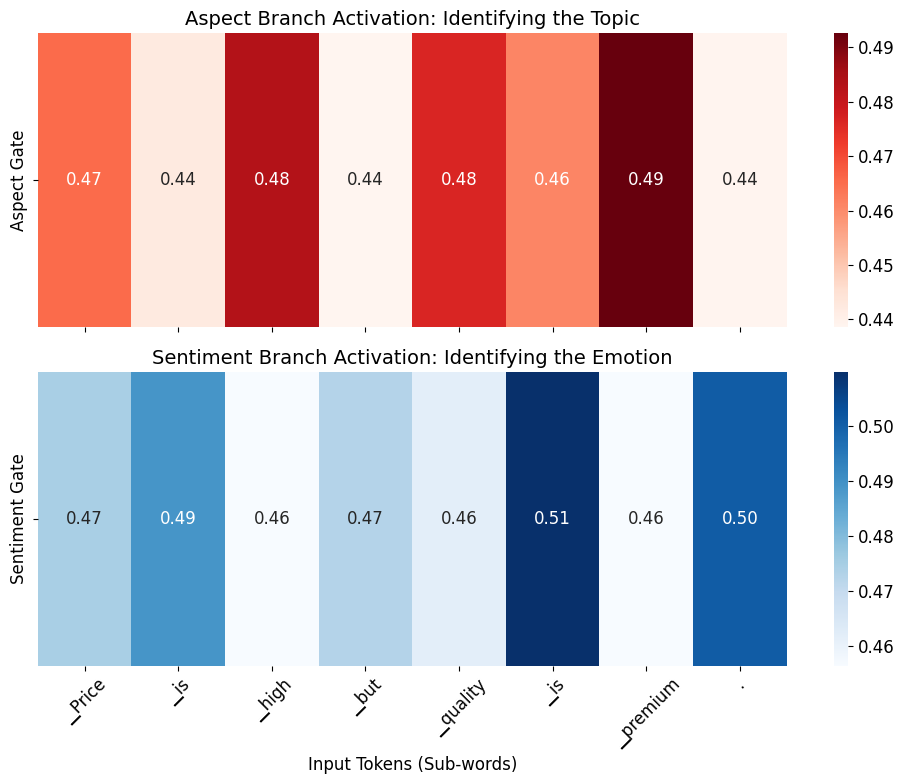

Visualization saved to: /content/drive/MyDrive/English_Aspect/results/case_3_price_analysis.png


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model

# ==========================================
# কনফিগারেশন
# ==========================================
results_dir = '/content/drive/MyDrive/English_Aspect/results' # আগের পাথ
# ফন্ট সাইজ একটু বড় রাখছি যাতে পেপারে পরিষ্কার দেখা যায়
plt.rcParams.update({'font.size': 12})

# ==========================================
# ১. ভিজ্যুয়ালাইজেশন ফাংশন (The Core Logic)
# ==========================================
def analyze_and_visualize(text_input, case_name="case_1"):
    print(f"\n--- Analyzing Case: '{text_input}' ---")

    # --- A. ইনপুট প্রসেসিং ---
    encoded = tokenizer(
        [text_input],
        padding='max_length',
        truncation=True,
        max_length=128,
        return_tensors='tf'
    )

    input_ids = encoded['input_ids']
    attention_mask = encoded['attention_mask']

    # টোকেনগুলো বের করা (গ্রাফের X-axis এর জন্য)
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    # প্যাডিং এবং স্পেশাল টোকেন ([CLS], [SEP], [PAD]) বাদ দিয়ে ক্লিন টোকেন লিস্ট
    # আমরা ভিজ্যুয়ালাইজেশনে প্রথম ১০-১৫টি শব্দ দেখাবো যাতে গ্রাফ হিজিবিজি না হয়
    seq_len = tf.reduce_sum(attention_mask).numpy() # আসল শব্দের সংখ্যা
    active_tokens = tokens[1:seq_len-1] # [CLS] এবং [SEP] বাদ

    # --- B. মডেলের ভেতর থেকে ফিচার বের করা ---
    # ১. এম্বেডিং বের করা (DeBERTa Output)
    # আমরা একটি সাব-মডেল বানাচ্ছি যা শুধু DeBERTa-র আউটপুট দিবে
    deberta_layer = model.layers[2] # ইনপুট লেয়ারের পরেই সাধারণত থাকে
    # নিরাপদ উপায়ে লেয়ার খোঁজা
    for layer in model.layers:
        if 'deberta' in layer.name or 'tf_model' in layer.name:
            deberta_layer = layer
            break

    # সাব-মডেল তৈরি
    embedding_model = Model(inputs=model.inputs, outputs=deberta_layer.output.last_hidden_state)
    embeddings = embedding_model.predict([input_ids, attention_mask]) # Shape: (1, 128, 768)

    # ২. Gated CNN Activation বের করা (Novelty Visualization)
    # আমরা ম্যানুয়ালি লেয়ারের 'gate' অংশটি কল করব
    aspect_gcnn_layer = model.get_layer('aspect_gcnn')
    sentiment_gcnn_layer = model.get_layer('sentiment_gcnn')

    # গেট লেয়ার (Sigmoid) এর আউটপুট বের করা
    # embeddings কেটে ছোট করছি আসল শব্দের মাপে
    active_embeddings = embeddings[:, 1:seq_len-1, :]

    # গেট ভ্যালু ক্যালকুলেশন (Aspect Branch)
    # GatedCNN ক্লাসের self.gate কনভলুশন লেয়ারটি এক্সেস করছি
    aspect_gate_values = aspect_gcnn_layer.gate(active_embeddings).numpy()[0] # (Seq, Filters)
    # সব ফিল্টারের গড় নিচ্ছি (Mean Activation across channels)
    aspect_gate_avg = np.mean(aspect_gate_values, axis=-1)

    # গেট ভ্যালু ক্যালকুলেশন (Sentiment Branch)
    sentiment_gate_values = sentiment_gcnn_layer.gate(active_embeddings).numpy()[0]
    sentiment_gate_avg = np.mean(sentiment_gate_values, axis=-1)

    # --- C. Attention Heatmap (DeBERTa) ---
    # DeBERTa-র অ্যাটেনশন সরাসরি এক্সেস করা একটু ট্রিকি Keras এ।
    # আমরা এখানে সিম্পলিসিটির জন্য Gated CNN এর অ্যাক্টিভেশনকেই 'Attention' হিসেবে দেখাবো
    # কারণ আমাদের মডেলে Gated CNN টাই আসলে লোকাল অ্যাটেনশনের কাজ করছে।

    # --- D. প্লটিং (Publication Quality) ---

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Plot 1: Aspect Gate Activation
    # কোন শব্দগুলো Aspect ডিটেকশনের জন্য গেট ওপেন করেছে?
    sns.heatmap([aspect_gate_avg], xticklabels=active_tokens, yticklabels=['Aspect Gate'],
                cmap="Reds", cbar=True, ax=ax1, annot=True, fmt=".2f")
    ax1.set_title(f"Aspect Branch Activation: Identifying the Topic", fontsize=14)

    # Plot 2: Sentiment Gate Activation
    # কোন শব্দগুলো Sentiment ডিটেকশনের জন্য গেট ওপেন করেছে?
    sns.heatmap([sentiment_gate_avg], xticklabels=active_tokens, yticklabels=['Sentiment Gate'],
                cmap="Blues", cbar=True, ax=ax2, annot=True, fmt=".2f")
    ax2.set_title(f"Sentiment Branch Activation: Identifying the Emotion", fontsize=14)

    plt.xlabel("Input Tokens (Sub-words)", fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()

    # সেভ করা
    save_path = f"{results_dir}/{case_name}_analysis.png"
    plt.savefig(save_path, dpi=300) # হাই রেজুলেশন
    plt.show()
    print(f"Visualization saved to: {save_path}")

# ==========================================
# ২. কেস স্টাডি রান করা (উদাহরণ)
# ==========================================

# Case 1: Simple but clear
text_1 = "The packaging was torn and damaged."
analyze_and_visualize(text_1, "case_1_packaging")

# Case 2: Complex / Interaction (আপনার আপডেটের উদাহরণ)
text_2 = "Product is good but shipping took ages."
analyze_and_visualize(text_2, "case_2_interaction")

# Case 3: Mixed
text_3 = "Price is high but quality is premium."
analyze_and_visualize(text_3, "case_3_price")

Generating Predictions and Extracting Labels...
806/806 [==============================] - 80s 99ms/step

Calculating Metrics...
✅ Text Report saved to: /content/drive/MyDrive/English_Aspect/results/final_evaluation_report.txt
Joint Accuracy: 99.50%


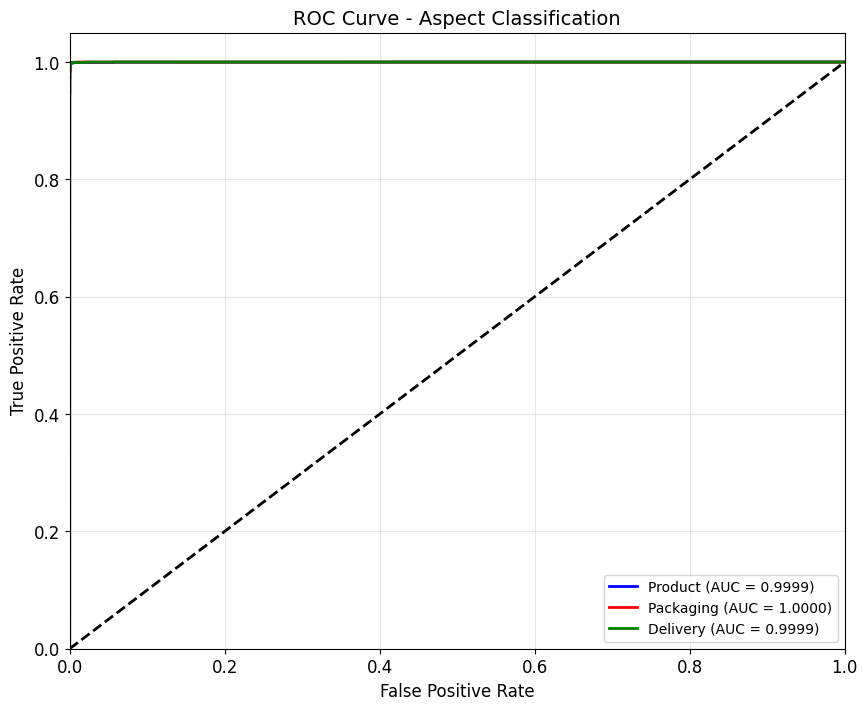

ROC Curve saved: roc_curve_aspect.png


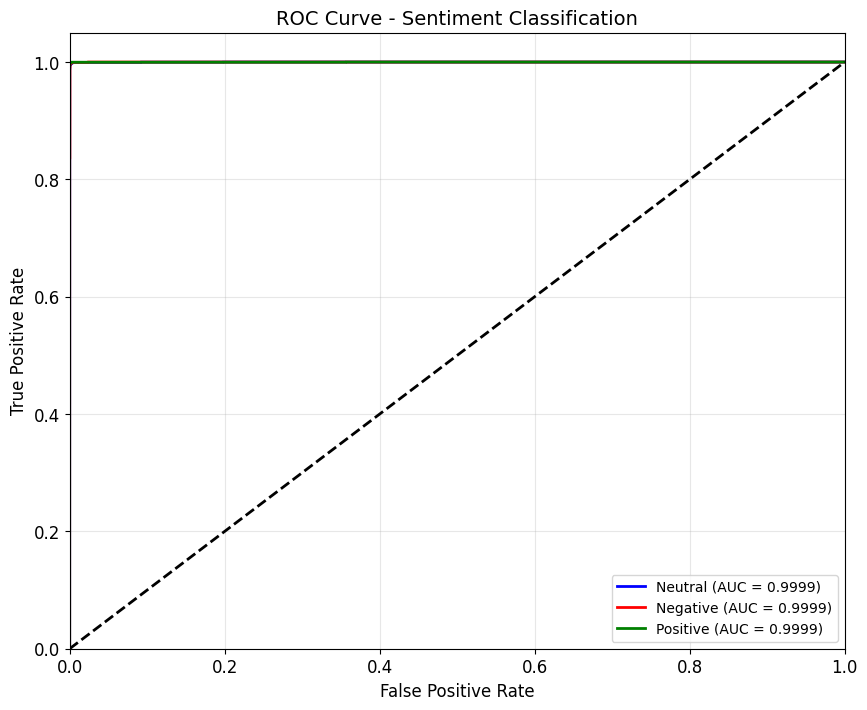

ROC Curve saved: roc_curve_sentiment.png


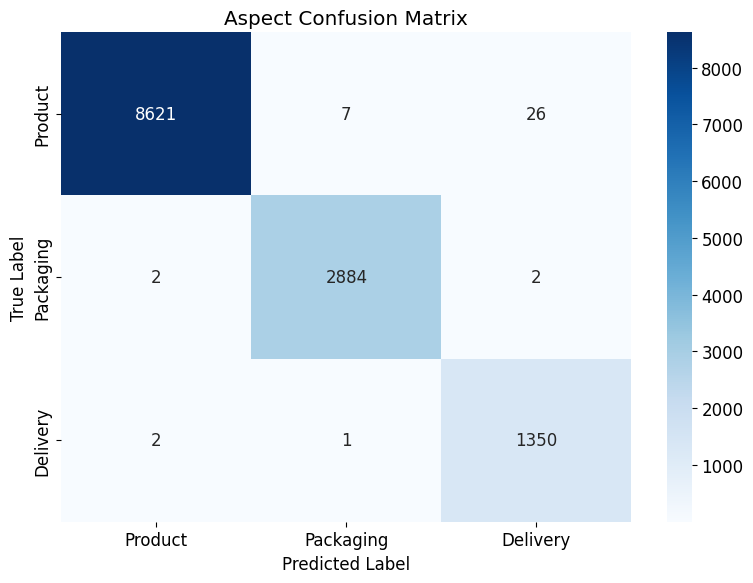

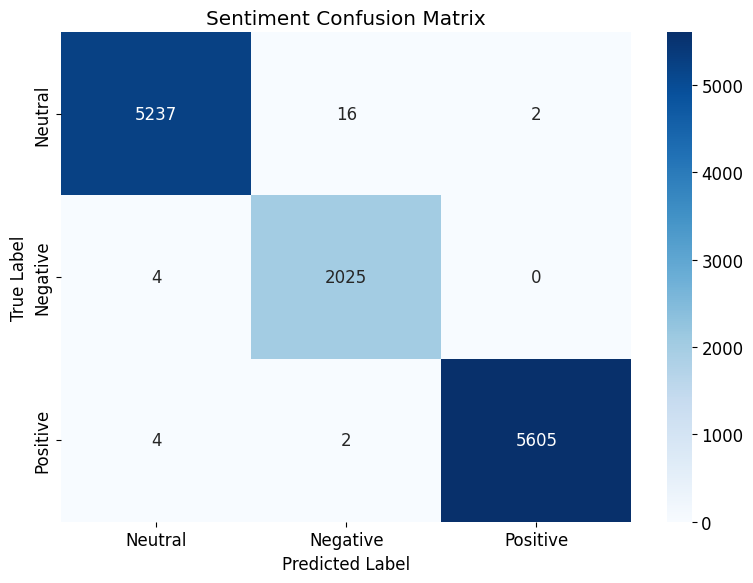

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import os

# ==========================================
# কনফিগারেশন
# ==========================================
results_dir = '/content/drive/MyDrive/English_Aspect/results'
os.makedirs(results_dir, exist_ok=True)

# ক্লাসের নাম (আপনার ম্যাপ অনুযায়ী)
aspect_labels = ['Product', 'Packaging', 'Delivery']
sentiment_labels = ['Neutral', 'Negative', 'Positive']

# ==========================================
# ১. ট্রু লেবেল (True Labels) এবং প্রেডিকশন বের করা
# ==========================================
print("Generating Predictions and Extracting Labels...")

y_true_asp = []
y_true_sen = []

# ভ্যালিডেশন ডেটাসেট থেকে আসল লেবেল বের করা
for batch in val_dataset:
    # batch[1] হলো আউটপুট ডিকশনারি {'aspect_output': ..., 'sentiment_output': ...}
    y_true_asp.extend(batch[1]['aspect_output'].numpy())
    y_true_sen.extend(batch[1]['sentiment_output'].numpy())

y_true_asp = np.array(y_true_asp)
y_true_sen = np.array(y_true_sen)

# মডেল প্রেডিকশন
val_pred = model.predict(val_dataset)
val_prob_asp = val_pred[0] # Raw Probabilities (ROC এর জন্য লাগবে)
val_prob_sen = val_pred[1]

# ক্লাস প্রেডিকশন (Argmax)
y_pred_asp = np.argmax(val_prob_asp, axis=1)
y_pred_sen = np.argmax(val_prob_sen, axis=1)

# ==========================================
# ২. মেট্রিক্স ক্যালকুলেশন (Accuracy, F1, Precision, Recall)
# ==========================================
print("\nCalculating Metrics...")

# A. Classification Report (Text Format)
report_asp = classification_report(y_true_asp, y_pred_asp, target_names=aspect_labels, digits=4)
report_sen = classification_report(y_true_sen, y_pred_sen, target_names=sentiment_labels, digits=4)

# B. Overall Accuracy
acc_asp = accuracy_score(y_true_asp, y_pred_asp)
acc_sen = accuracy_score(y_true_sen, y_pred_sen)
overall_acc = (acc_asp + acc_sen) / 2

# C. Joint Accuracy (আপনার আর্কিটেকচারের স্পেশাল মেট্রিক)
joint_correct = np.sum((y_pred_asp == y_true_asp) & (y_pred_sen == y_true_sen))
joint_acc = joint_correct / len(y_true_asp)

# রিপোর্ট সেভ করা
report_path = os.path.join(results_dir, 'final_evaluation_report.txt')
with open(report_path, 'w') as f:
    f.write("=== FINAL MODEL PERFORMANCE ===\n\n")
    f.write(f"Joint Accuracy (Both Correct): {joint_acc*100:.2f}%\n")
    f.write(f"Overall Accuracy: {overall_acc*100:.2f}%\n")
    f.write(f"Aspect Accuracy: {acc_asp*100:.2f}%\n")
    f.write(f"Sentiment Accuracy: {acc_sen*100:.2f}%\n\n")
    f.write("--- Aspect Classification Report ---\n")
    f.write(report_asp)
    f.write("\n\n--- Sentiment Classification Report ---\n")
    f.write(report_sen)

print(f"✅ Text Report saved to: {report_path}")
print(f"Joint Accuracy: {joint_acc*100:.2f}%")

# ==========================================
# ৩. ROC Curve জেনারেশন (Multi-Class)
# ==========================================
def plot_multiclass_roc(y_true, y_probs, labels, title, filename):
    n_classes = len(labels)

    # লেবেলগুলোকে বাইনারি (One-hot) করতে হবে ROC এর জন্য
    y_true_bin = label_binarize(y_true, classes=range(n_classes))

    plt.figure(figsize=(10, 8))

    # প্রতিটি ক্লাসের জন্য আলাদা কার্ভ
    colors = ['blue', 'red', 'green']
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=colors[i], lw=2,
                 label=f'{labels[i]} (AUC = {roc_auc:.4f})')

    # রেফারেন্স লাইন
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(title, fontsize=14)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)

    # সেভ করা
    save_path = os.path.join(results_dir, filename)
    plt.savefig(save_path, dpi=300) # হাই রেজুলেশন (Q1 এর জন্য)
    plt.show()
    print(f"ROC Curve saved: {filename}")

# প্লট কল করা
plot_multiclass_roc(y_true_asp, val_prob_asp, aspect_labels,
                    "ROC Curve - Aspect Classification", "roc_curve_aspect.png")

plot_multiclass_roc(y_true_sen, val_prob_sen, sentiment_labels,
                    "ROC Curve - Sentiment Classification", "roc_curve_sentiment.png")

# ==========================================
# ৪. Confusion Matrix (Visual Proof)
# ==========================================
def plot_cm(y_true, y_pred, labels, title, filename):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, filename))
    plt.show()

plot_cm(y_true_asp, y_pred_asp, aspect_labels, "Aspect Confusion Matrix", "cm_aspect.png")
plot_cm(y_true_sen, y_pred_sen, sentiment_labels, "Sentiment Confusion Matrix", "cm_sentiment.png")

In [ ]:
print(report_asp)

              precision    recall  f1-score   support

     Product     0.9995    0.9962    0.9979      8654
   Packaging     0.9972    0.9986    0.9979      2888
    Delivery     0.9797    0.9978    0.9886      1353

    accuracy                         0.9969     12895
   macro avg     0.9922    0.9975    0.9948     12895
weighted avg     0.9969    0.9969    0.9969     12895



In [ ]:
print(report_sen)

              precision    recall  f1-score   support

     Neutral     0.9985    0.9966    0.9975      5255
    Negative     0.9912    0.9980    0.9946      2029
    Positive     0.9996    0.9989    0.9993      5611

    accuracy                         0.9978     12895
   macro avg     0.9964    0.9978    0.9971     12895
weighted avg     0.9978    0.9978    0.9978     12895



Training history loaded successfully.
   epoch  aspect_output_accuracy  aspect_output_loss      loss  \
0      0                0.938560            0.154094  0.365303   
1      1                0.986157            0.030999  0.079141   
2      2                0.993738            0.014919  0.039114   
3      3                0.995812            0.010328  0.023013   
4      4                0.997072            0.008088  0.021023   

   sentiment_output_accuracy  sentiment_output_loss  \
0                   0.914830               0.211210   
1                   0.982047               0.048142   
2                   0.991217               0.024194   
3                   0.995134               0.012685   
4                   0.995870               0.012936   

   val_aspect_output_accuracy  val_aspect_output_loss  val_loss  \
0                    0.981078                0.060042  0.112387   
1                    0.994416                0.018813  0.049279   
2                    0.995657    

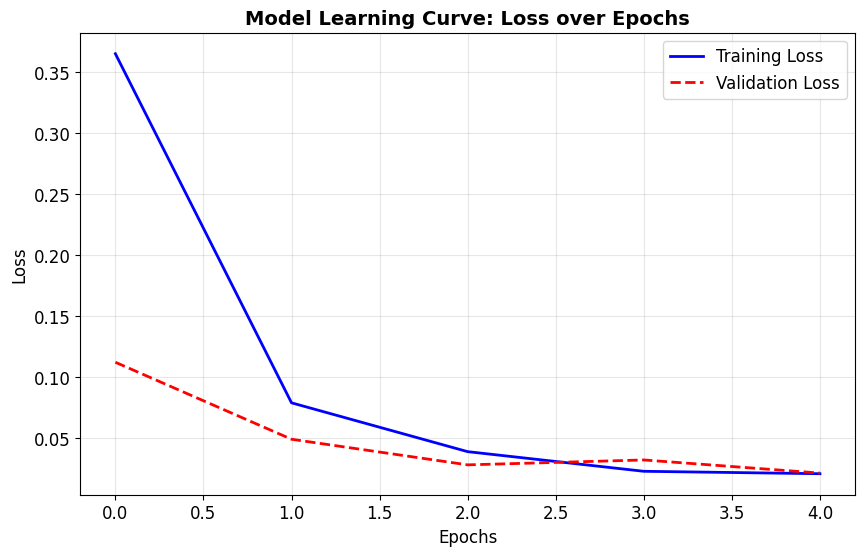

Loss Curve saved to: /content/drive/MyDrive/English_Aspect/results/learning_curve_loss.png


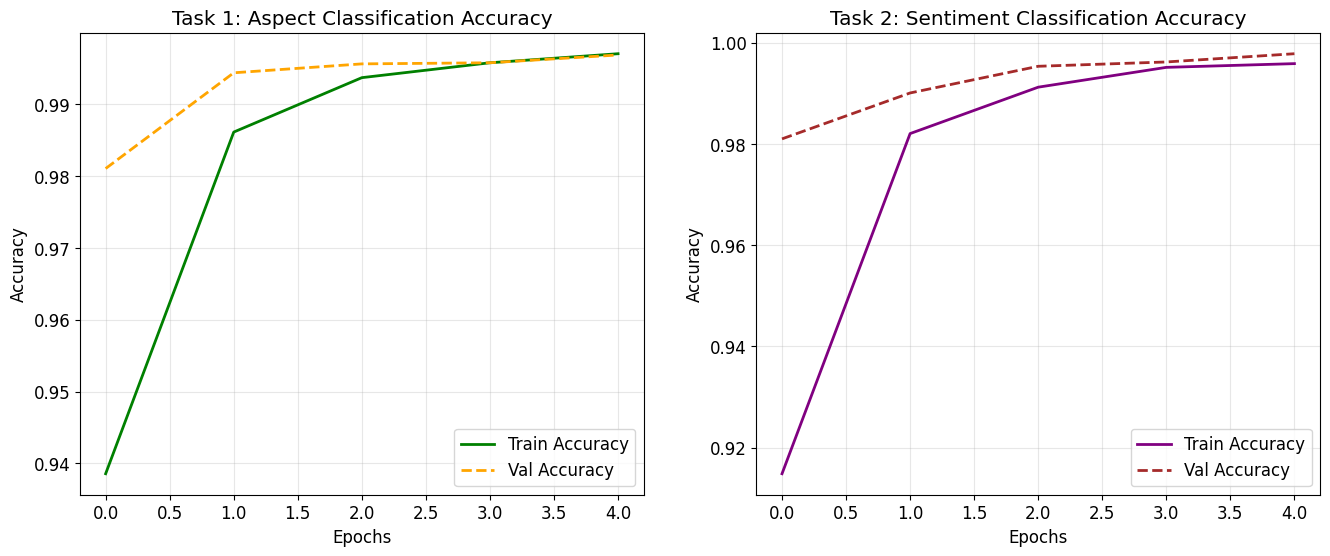

Accuracy Curve saved to: /content/drive/MyDrive/English_Aspect/results/learning_curve_accuracy.png


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# ==========================================
# কনফিগারেশন
# ==========================================
results_dir = '/content/drive/MyDrive/English_Aspect/results'
history_file = os.path.join(results_dir, 'training_history.csv')

# ফন্টের সাইজ সেট করা (পেপারের জন্য একটু বড় ফন্ট ভালো)
plt.rcParams.update({'font.size': 12})

# ==========================================
# ১. হিস্ট্রি ফাইল লোড করা
# ==========================================
try:
    df = pd.read_csv(history_file)
    print("Training history loaded successfully.")
    print(df.head()) # ডেটার প্রথম কয়েকটা লাইন দেখা
except FileNotFoundError:
    print("❌ Error: 'training_history.csv' not found. Please check if training finished successfully.")

# ==========================================
# ২. Loss Curve (Training vs Validation)
# ==========================================
plt.figure(figsize=(10, 6))

# টোটাল লস প্লট করা
plt.plot(df['epoch'], df['loss'], label='Training Loss', color='blue', linewidth=2, linestyle='-')
plt.plot(df['epoch'], df['val_loss'], label='Validation Loss', color='red', linewidth=2, linestyle='--')

plt.title('Model Learning Curve: Loss over Epochs', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

# সেভ করা
loss_path = os.path.join(results_dir, 'learning_curve_loss.png')
plt.savefig(loss_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"Loss Curve saved to: {loss_path}")

# ==========================================
# ৩. Accuracy Curve (Aspect & Sentiment Combined)
# ==========================================
# আমরা দুটি সাব-প্লট বানাবো: বাম পাশে Aspect, ডান পাশে Sentiment

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# --- Plot A: Aspect Accuracy ---
# কলামের নাম Keras ভার্সন অনুযায়ী ভিন্ন হতে পারে, তাই চেক করে নেওয়া ভালো
# সাধারণত: 'aspect_output_accuracy' বা 'accuracy'
asp_acc = df.get('aspect_output_accuracy', df.get('accuracy')) # সেইফ গেট
val_asp_acc = df.get('val_aspect_output_accuracy', df.get('val_accuracy'))

ax1.plot(df['epoch'], asp_acc, label='Train Accuracy', color='green', linewidth=2)
ax1.plot(df['epoch'], val_asp_acc, label='Val Accuracy', color='orange', linewidth=2, linestyle='--')
ax1.set_title('Task 1: Aspect Classification Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)

# --- Plot B: Sentiment Accuracy ---
sen_acc = df.get('sentiment_output_accuracy')
val_sen_acc = df.get('val_sentiment_output_accuracy')

if sen_acc is not None:
    ax2.plot(df['epoch'], sen_acc, label='Train Accuracy', color='purple', linewidth=2)
    ax2.plot(df['epoch'], val_sen_acc, label='Val Accuracy', color='brown', linewidth=2, linestyle='--')
    ax2.set_title('Task 2: Sentiment Classification Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend(loc='lower right')
    ax2.grid(True, alpha=0.3)
else:
    print("Warning: Sentiment Accuracy columns not found (maybe single output model?)")

# সেভ করা
acc_path = os.path.join(results_dir, 'learning_curve_accuracy.png')
plt.savefig(acc_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"Accuracy Curve saved to: {acc_path}")